# Intro
Recommender systems are all over the place, assisting you in your search for everything from books to romantic dates, hotels to restaurants.

There are several recommender systems for various scenarios, depending on your needs and accessible data.


## Data 
In our situation, the purpose is to build a recommender system using implicit data , which is clickstream ecommerce website in specialized cosmetics

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.


<table>
<thead>
<tr>
<th>Property</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>event_time</strong></td>
<td>Time when event happened at (in UTC).</td>
</tr>
<tr>
<td><strong>event_type</strong></td>
<td>Only one kind of event: purchase.</td>
</tr>
<tr>
<td><strong>product_id</strong></td>
<td>ID of a product</td>
</tr>
<tr>
<td><strong>category_id</strong></td>
<td>Product's category ID</td>
</tr>
<tr>
<td><strong>category_code</strong></td>
<td>Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.</td>
</tr>
<tr>
<td><strong>brand</strong></td>
<td>Downcased string of brand name. Can be missed.</td>
</tr>
<tr>
<td><strong>price</strong></td>
<td>Float price of a product. Present.</td>
</tr>
<tr>
<td><strong>user_id</strong></td>
<td>Permanent user ID.</td>
</tr>
<tr>
<td>** user_session**</td>
<td>Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.</td>
</tr>
</tbody>
</table>

### The Event types are:

<li><code>view</code> - a user viewed a product</li>
<li><code>cart</code> - a user added a product to shopping cart</li>
<li><code>remove_from_cart</code> - a user removed a product from shopping cart</li>
<li><code>purchase</code> - a user purchased a product</li>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Nov.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Feb.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Oct.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2019-Dec.csv
/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv


## Importing relevent libraries

In [2]:
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.sparse as sparse
import implicit
sns.set()
style.use('ggplot')
%matplotlib inline 
dask.config.set(scheduler='processes')
plt.rcParams["figure.figsize"] = (12, 8)

## Reading Data 

In [3]:
%%time
ddf = dd.read_csv("/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv", dtype={'category_code': 'object'})
ddf.head()

CPU times: user 28.1 ms, sys: 35.7 ms, total: 63.8 ms
Wall time: 4.98 s


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb


## Checking for null values

In [4]:
ddf.isnull().sum().compute()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    4190033
brand            1775630
price                  0
user_id                0
user_session        1314
dtype: int64

# Data Analysis


## Ckecking the data distributions

### Event types

view                2037608
cart                1148323
remove_from_cart     815024
purchase             263797
Name: event_type, dtype: int64
CPU times: user 87.9 ms, sys: 71.8 ms, total: 160 ms
Wall time: 11.7 s


<AxesSubplot:title={'center':'Event types distribution'}>

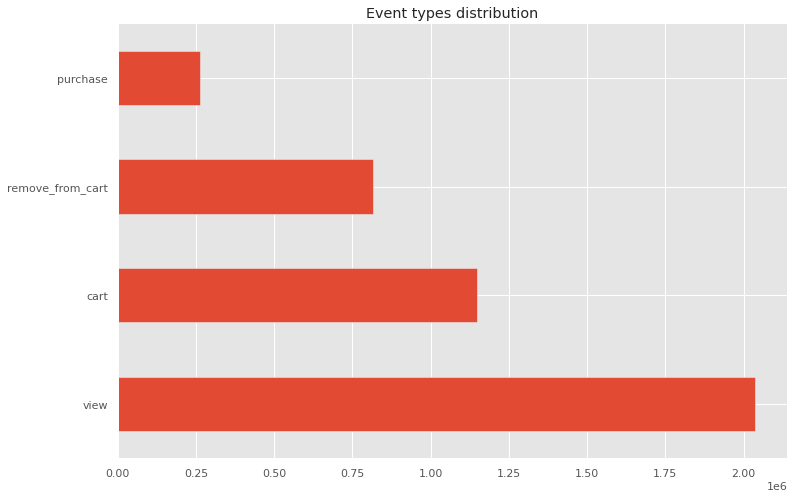

In [5]:
%%time
ET = ddf.event_type.value_counts().compute()
print(ET)
ET.plot(kind='barh',title='Event types distribution')

### Cetegory codes

appliances.environment.vacuum             32104
apparel.glove                             13479
stationery.cartrige                       11469
furniture.living_room.cabinet              6114
furniture.bathroom.bath                    5139
accessories.bag                            4076
appliances.personal.hair_cutter            1225
accessories.cosmetic_bag                    809
appliances.personal.massager                169
appliances.environment.air_conditioner      128
Name: category_code, dtype: int64
CPU times: user 80.7 ms, sys: 67.5 ms, total: 148 ms
Wall time: 11.4 s


<AxesSubplot:title={'center':'Cetegory code distribution'}>

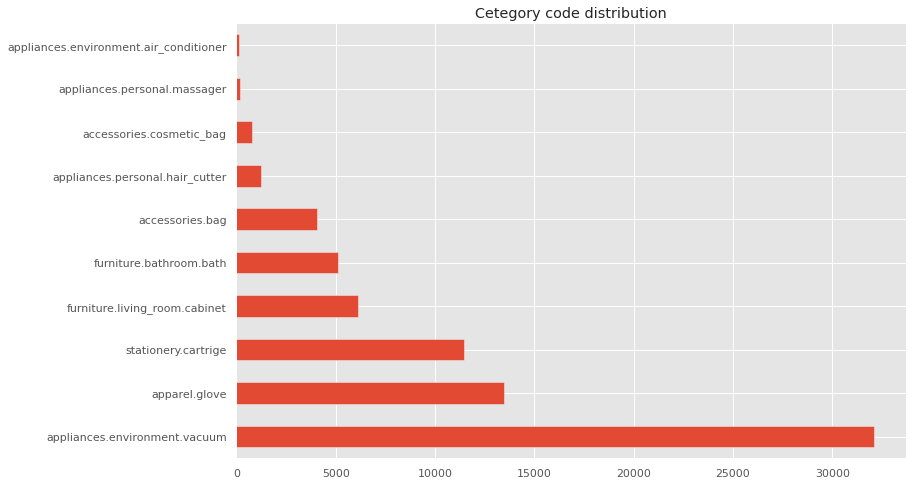

In [6]:
%%time
CC = ddf.category_code.value_counts().compute()
print(CC.head(10))
CC.head(10).plot(kind='barh',title='Cetegory code distribution')

### Brands

runail       368018
irisk        210875
masura       203526
grattol      193829
estel         82032
ingarden      78388
kapous        76299
bpw.style     55524
jessnail      54523
uno           53625
Name: brand, dtype: int64
CPU times: user 105 ms, sys: 66.7 ms, total: 172 ms
Wall time: 11.7 s


<AxesSubplot:title={'center':'Brand distribution'}>

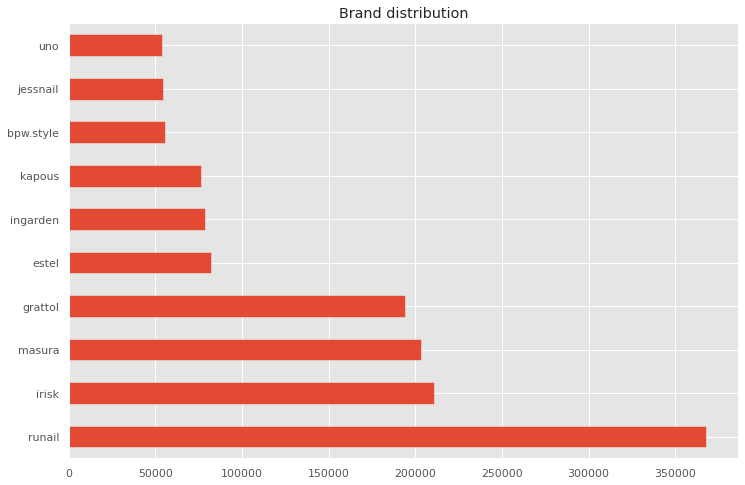

In [7]:
%%time

B = ddf.brand.value_counts().compute()
print(B.head(10))
B.head(10).plot(kind='barh',title='Brand distribution')

runail       26596
irisk        14827
masura       12234
grattol      11828
ingarden      5156
estel         4504
bpw.style     4175
uno           3811
italwax       3455
kapous        3212
Name: brand, dtype: int64
CPU times: user 109 ms, sys: 55.7 ms, total: 165 ms
Wall time: 11.7 s


<AxesSubplot:title={'center':'Purchased brands distribution'}>

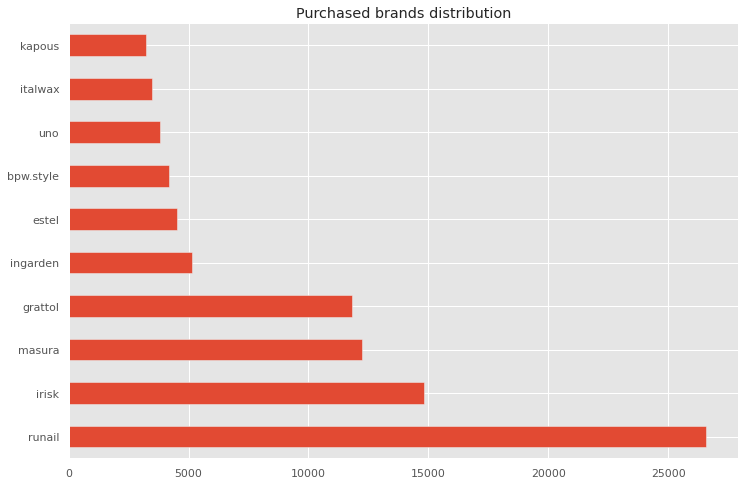

In [8]:
%%time
PET = ddf[ddf['event_type'] == 'purchase'].brand.value_counts().compute()
print(PET.head(10))
PET.head(10).plot(kind='barh',title='Purchased brands distribution')

### Day of the week

# Data preprocessing

In [11]:
%%time
event_type_strength = {
    'view': 1,
    'cart': 2,
    'remove_from_cart':-1,
    'purchase': 3
}

ddf['event_strength'] = ddf['event_type'].map(lambda x: event_type_strength[x],meta=pd.Series([], dtype=int, name='event_strength'))
ddf.head(10)


CPU times: user 10.7 s, sys: 864 ms, total: 11.5 s
Wall time: 27.6 s


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_strength
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,1
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,1
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,1
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,1
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,1
5,2020-01-01 00:00:30 UTC,view,5837111,1783999068867920626,NaN,staleks,6.35,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,1
6,2020-01-01 00:00:37 UTC,cart,5850281,1487580006300255120,NaN,marathon,137.78,593016733,848f607c-1d14-474a-8869-c40e60783c9d,2
7,2020-01-01 00:00:46 UTC,view,5802440,2151191070908613477,NaN,NaN,2.16,595411904,74ca1cd5-5381-4ffe-b00b-a258b390db77,1
8,2020-01-01 00:00:57 UTC,view,5726464,1487580005268456287,NaN,NaN,5.56,420652863,546f6af3-a517-4752-a98b-80c4c5860711,1
9,2020-01-01 00:01:02 UTC,remove_from_cart,5850281,1487580006300255120,NaN,marathon,137.78,593016733,848f607c-1d14-474a-8869-c40e60783c9d,-1


 1    2037501
 2    1128662
-1     609884
 3     263605
Name: event_strength, dtype: int64
CPU times: user 3min 28s, sys: 4.75 s, total: 3min 32s
Wall time: 6min 42s


<AxesSubplot:>

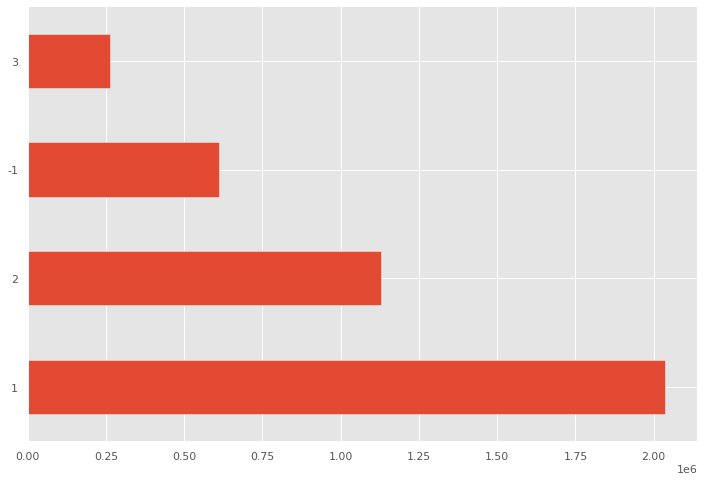

In [25]:
%%time
ET = ddf.event_strength.value_counts().compute()
print(ET)
ET.plot(kind='barh')

# SECTION IN PROGRESS

In [13]:
ddf

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_strength
npartitions=7,,,,,,,,,,
,object,object,int64,int64,object,object,float64,int64,object,int64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [14]:
%%time
ddf = ddf.drop_duplicates()
grouped = ddf.groupby(['user_id', 'product_id']).event_strength.sum(split_out=14).reset_index()

CPU times: user 32.6 ms, sys: 1.97 ms, total: 34.6 ms
Wall time: 38.4 ms


In [15]:
grouped

,user_id,product_id,event_strength
npartitions=14,,,
,int64,int64,int64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [16]:
grouped = grouped.reset_index()

In [17]:


sparse_content_person = sparse.csr_matrix((grouped['event_strength'].astype(float), (grouped['product_id'], grouped['user_id'])))

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_content_person * alpha).astype('double')
model.fit(data)

Process SpawnProcess-39:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process SpawnProcess-40:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/

KeyboardInterrupt: 

In [ ]:
grouped = grouped[grouped.event_strength > 1]
grouped